![picture](https://doc.google.com/uc?id=1-SCmtVCHxEXXpBfRMwvY_gBrDFA6Pb3u)
# **The Tomato Leaf Disease Type Classification Project**

In this notebook, we will present how to perform a classification of car brands. 
We will use different state of the art classifiers in Tensorflow 2.0 and Keras.




# Summary

- **Name:** Byju N Govindan
- **Date:** 20 September 2021
- **Use Case:** Vehicle Type
- **Algorithm:** ResNet50
- **Number of training images:** 8632
- **Number of validation images:** 1079
- **Number of training images:** 1080
- **Number of classes:** 10
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet

**Comments:** We obtained xx% on the validation accuracy on tomato leaf disease types, on validation dataset.

Let's get started.

We first need to load the requires libraries

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [2]:
print(tf.__version__)

2.9.2


Then, we mount Google Drive to be able to access the files located on it

We now specify the path the dataset located on Google Drive

In [3]:
TYPE='type'
model_type='resnet50'
user='byju'
iteration='1'

first_time_training=True

PROJECT_PATH='/content/drive/MyDrive/TLDArchive2/tomato2/'
print('PROJECT_PATH: ',PROJECT_PATH)
HDF5_DATASET_PATH=PROJECT_PATH+'h5-dataset/tomato-disease-type-dataset-SIZE224-train-dev-test-v2.hdf5'
print(HDF5_DATASET_PATH)
ACCURACY_LOSS_OUPUT_FILE=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-accuracy-loss-'+user+'-'+iteration+'.jpg'
print('ACCURACY_LOSS_OUPUT_FILE: ', ACCURACY_LOSS_OUPUT_FILE)
TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'trained-models/'+model_type+'/'+'tomato-leaf-disease-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
CHECKPOINT_PATH = PROJECT_PATH+'checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
LOGFILE_PATH=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  /content/drive/MyDrive/TLDArchive2/tomato2/
/content/drive/MyDrive/TLDArchive2/tomato2/h5-dataset/tomato-disease-type-dataset-SIZE224-train-dev-test-v2.hdf5
ACCURACY_LOSS_OUPUT_FILE:  /content/drive/MyDrive/TLDArchive2/tomato2/log/resnet50/resnet50-by-type-accuracy-loss-byju-1.jpg
TARGET_CLASSIFICATION_MODEL:  /content/drive/MyDrive/TLDArchive2/tomato2/trained-models/resnet50/tomato-leaf-disease-classification-by-type-resnet50-byju-1.h5
CHECKPOINT_PATH:  /content/drive/MyDrive/TLDArchive2/tomato2/checkpoints/resnet50/by-type-resnet50-byju-1.h5
LOGFILE_PATH:  /content/drive/MyDrive/TLDArchive2/tomato2/log/resnet50/resnet50-by-type-training-logbyju-1.csv


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

sys.path.append('/content/drive/MyDrive/TLDArchive2/')
import anis_koubaa_udemy_computer_vision_lib  
from anis_koubaa_udemy_computer_vision_lib import *

# **Load the Dataset**

In [6]:
def load_dataset_from_hdf5_file(hdf_file_path):
  hf = h5py.File(hdf_file_path, "r")
  trainX= np.array(hf["trainX"]).astype("f8")
  ascii_train_labels = np.array(hf["trainLabels"]).astype("S65")
  trainY=np.array(hf["trainY"]).astype("int")

  devX= np.array(hf["devX"]).astype("f8")
  ascii_dev_labels = np.array(hf["devLabels"]).astype("S65")
  devY=np.array(hf["devY"]).astype("int")

  testX= np.array(hf["testX"]).astype("f8")
  ascii_test_labels = np.array(hf["testLabels"]).astype("S65")
  testY=np.array(hf["testY"]).astype("int")

  trainLabels = np.array([n.decode('unicode_escape') for n in ascii_train_labels])
  devLabels = np.array([n.decode('unicode_escape') for n in ascii_dev_labels])
  testLabels = np.array([n.decode('unicode_escape') for n in ascii_test_labels])

  print("trainX.shape: ",trainX.shape)
  print("trainY.shape: ",trainY.shape)
  print("trainLabels.shape: ",trainLabels.shape)
  print("devX.shape: ",devX.shape)
  print("devY.shape: ",devY.shape)
  print("devLabels.shape: ",devLabels.shape)
  print("testX.shape: ",testX.shape)
  print("testY.shape: ",testY.shape)
  print("testLabels.shape: ",testLabels.shape)

  return trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels

In [7]:
trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels=load_dataset_from_hdf5_file(HDF5_DATASET_PATH)

trainX.shape:  (8632, 224, 224, 3)
trainY.shape:  (8632, 10)
trainLabels.shape:  (8632,)
devX.shape:  (1079, 224, 224, 3)
devY.shape:  (1079, 10)
devLabels.shape:  (1079,)
testX.shape:  (1080, 224, 224, 3)
testY.shape:  (1080, 10)
testLabels.shape:  (1080,)


In [8]:
IMAGE_SIZE=trainX.shape[1]
print(IMAGE_SIZE)

224


In [9]:
number_of_classes=np.unique(trainLabels).size

# **Dataset Visualization**

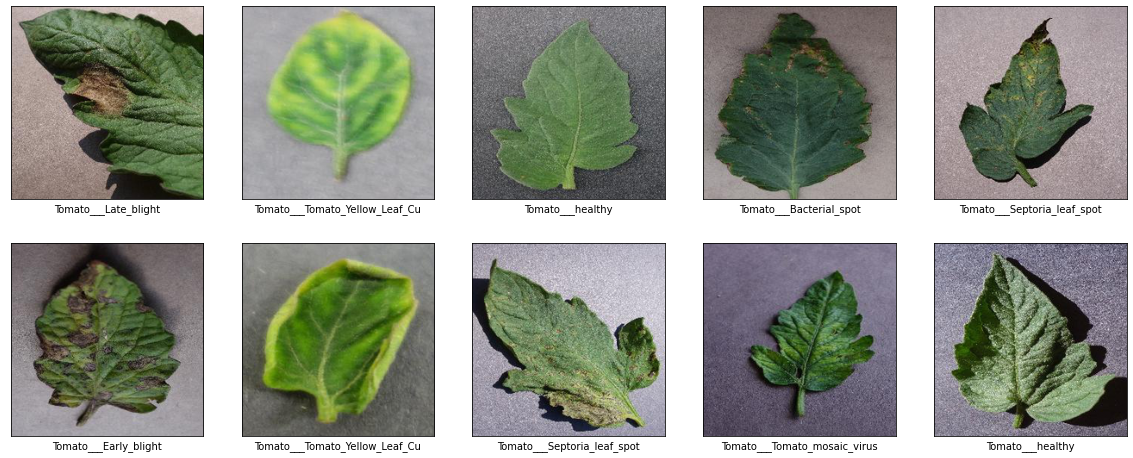

In [10]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(trainX, trainLabels,rows=2, colums=5, width=20,height=8)


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


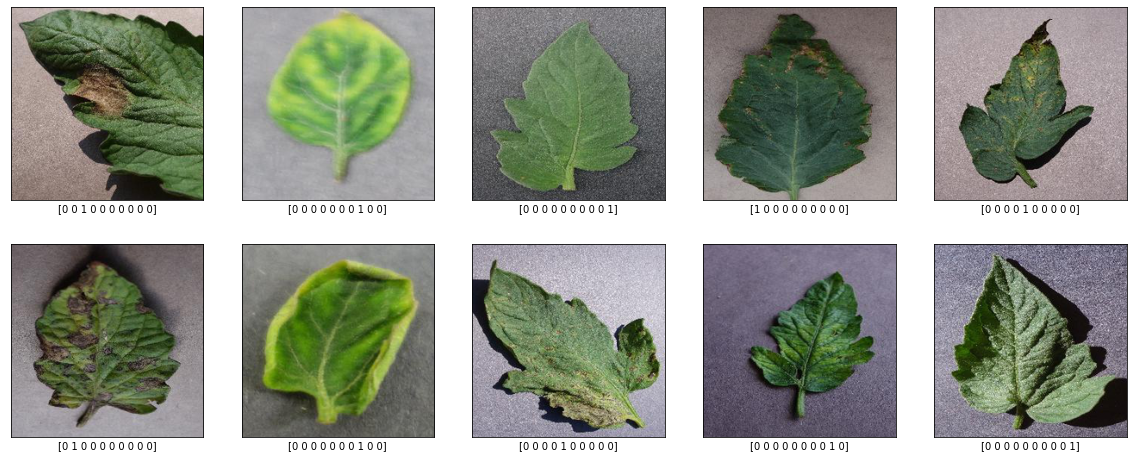

In [11]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(trainX, trainY,rows=2, colums=5, width=20,height=8)

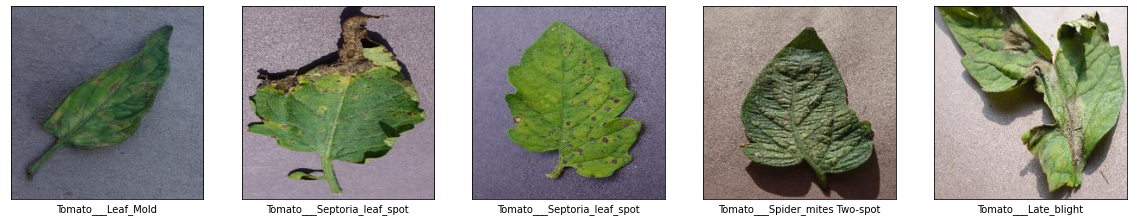

In [12]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX, devLabels,rows=1, colums=5, width=20,height=8)

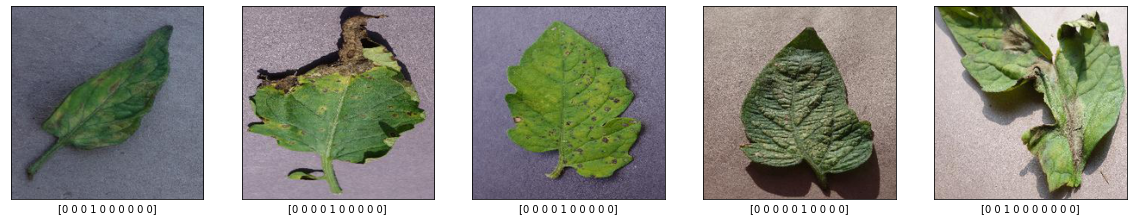

In [13]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX, devY,rows=1, colums=5, width=20,height=8)

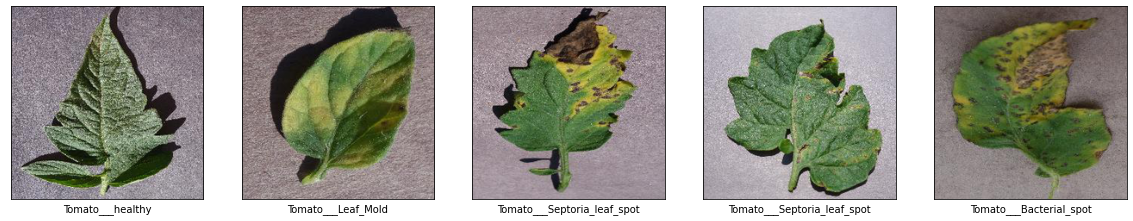

In [14]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX, testLabels,rows=1, colums=5, width=20,height=8)

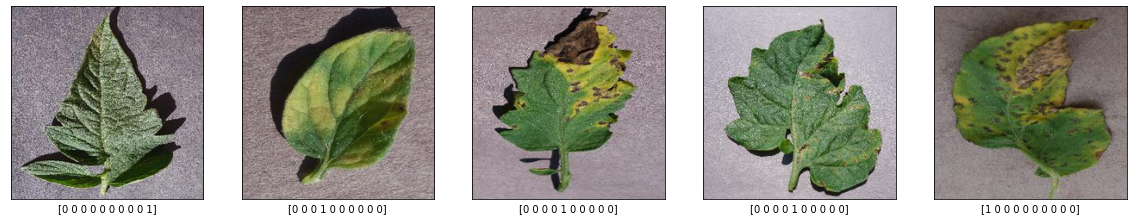

In [15]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX, testY,rows=1, colums=5, width=20,height=8)

# Training Configuration

# Data Augmentation

In [16]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=20)
	#fill_mode="nearest")
	#brightness_range=[0.2,1.0])
	#horizontal_flip=True)

In [17]:
# load the network, ensuring the head FC layer sets are left
# off
if (first_time_training==True):
    print('training for first time')
    baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3)))

training for first time
94765736/94765736 [==============================] - 0s 0us/step


In [18]:
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(number_of_classes, activation="softmax")(headModel)

In [19]:
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

In [20]:
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False

    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
#disable this instruction if you train for the first time
#enable it when you for the second time or after
if (first_time_training==False):
    model = tf.keras.models.load_model(TARGET_CLASSIFICATION_MODEL)

#for layer in model.layers[0:-8]:
#    layer.trainable = False

#    model.summary()

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [23]:
#import tf.keras.callbacks.Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle
#!mkdir -p '/content/drive/My Drive/anis-koubaa-projects/car-classification-project/checkpoints'

cp1= ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1, mode='auto')
csv_logger = CSVLogger(LOGFILE_PATH,append=True)

callbacks_list = [cp1,csv_logger]

In [24]:
#SET THE HYPERPARAMETERS OF THE TRAINING

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
BETA_1=0.9
BETA_2=0.999
EPSILON=1e-08

INITIAL_EPOCH=0
EPOCHS = INITIAL_EPOCH+100
BS = 64




# compile our model
print("[INFO] compiling model...")

#opt=tf.keras.optimizers.Adagrad(learning_rate=INIT_LR, initial_accumulator_value=0.1, epsilon=1e-07, name='Adagrad', decay=INIT_LR / EPOCHS)
opt = Adam(learning_rate=INIT_LR, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=INIT_LR/ EPOCHS)
#opt = SGD (learning_rate=INIT_LR, momentum = 0.9, decay=INIT_LR / EPOCHS)



[INFO] compiling model...


In [25]:
#COMPILE THE MODEL
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=["accuracy"])

In [26]:
#create folder if they do not exists
LOG_PATH=PROJECT_PATH+'log/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
LOG_PATH=PROJECT_PATH+'checkpoints/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

In [ ]:
# train the head of the network
print("[INFO] training head...")
history = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(devX, devY),
	validation_steps=len(devX) // BS,
	epochs=EPOCHS, callbacks=callbacks_list, initial_epoch=INITIAL_EPOCH)

[INFO] training head...
Epoch 1/100


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


134/134 [==============================] - ETA: 0s - loss: 2.5537 - accuracy: 0.1685
Epoch 1: val_accuracy improved from -inf to 0.14736, saving model to /content/drive/MyDrive/TLDArchive2/tomato2/checkpoints/resnet50/by-type-resnet50-byju-1.h5
134/134 [==============================] - 97s 635ms/step - loss: 2.5537 - accuracy: 0.1685 - val_loss: 2.2998 - val_accuracy: 0.1474
Epoch 2/100
134/134 [==============================] - ETA: 0s - loss: 2.2208 - accuracy: 0.2505
Epoch 2: val_accuracy improved from 0.14736 to 0.20945, saving model to /content/drive/MyDrive/TLDArchive2/tomato2/checkpoints/resnet50/by-type-resnet50-byju-1.h5
134/134 [==============================] - 81s 607ms/step - loss: 2.2208 - accuracy: 0.2505 - val_loss: 2.2594 - val_accuracy: 0.2095
Epoch 3/100
134/134 [==============================] - ETA: 0s - loss: 2.0559 - accuracy: 0.3026
Epoch 3: val_accuracy improved from 0.20945 to 0.27433, saving model to /content/drive/MyDrive/TLDArchive2/tomato2/checkpoints/res

In [ ]:
LOG_PATH=PROJECT_PATH+'trained-models/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
model.save(TARGET_CLASSIFICATION_MODEL)

# See Results

In [ ]:
# anis_koubaa_udemy_computer_vision_lib.plot_loss_accuracy_from_csv(LOGFILE_PATH)
# This did not work

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_history(history):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.title('Model Classification Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.title('Model Cross Entropy Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [ ]:
print('Loading the best model...')
import datetime
t0 = datetime.datetime.now()
test_model = tf.keras.models.load_model(TARGET_CLASSIFICATION_MODEL)
t1 = datetime.datetime.now()
print('time to load the model: ', (t1-t0))

Loading the best model...
time to load the model:  0:00:01.849342


In [ ]:
# make predictions on the validation set
print("[INFO] evaluating network on the dev dataset...")
test_model.evaluate(devX, devY,verbose=0)

[INFO] evaluating network on the dev dataset...


[2.4953320026397705, 0.4300278127193451]

In [ ]:
print("[INFO] evaluating network on the test dataset...")
test_model.evaluate(testX, testY,verbose=0)

[INFO] evaluating network on the test dataset...


[2.512033700942993, 0.4296296238899231]

In [ ]:
# evaluate model
train_loss, train_acc = test_model.evaluate(trainX, trainY, verbose=0)
val_loss, val_acc = test_model.evaluate(devX, devY, verbose=0)
test_loss, test_acc = test_model.evaluate(testX, testY, verbose=0)
#	print('> %.3f' % (acc * 100.0))
print('Train Accuracy: %.3f, Validation Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc * 100.0, val_acc * 100.0, test_acc * 100.0))
print('Train Loss: %.3f, Validation Loss: %.3f, Test Loss: %.3f' % (train_loss, val_loss, test_loss))


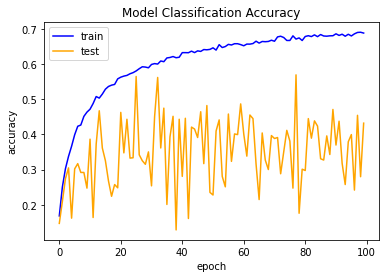

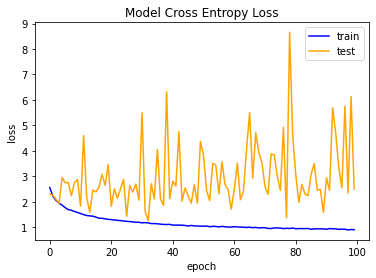

In [ ]:
plot_history(history)